# 1. Starting with Scikit-learn
## 1. Loading the dataset
- Scikit-learn comes with some datasets for experimenting with class labels already being integers

In [1]:
from sklearn import datasets
import numpy as np

iris = datasets.load_iris()
X = iris.data[:, [2, 3]]
y = iris.target

print('Class labels:', np.unique(y))

Class labels: [0 1 2]


## 2. Splitting data into 70% training and 30% test data:
- "stratify" option allows us to preserve the proportions between the labels from the dataset in both training and testing sets (1:1:1 for 3 classes in this case)

In [2]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y)

print('Labels counts in y:', np.bincount(y))
print('Labels counts in y_train:', np.bincount(y_train))
print('Labels counts in y_test:', np.bincount(y_test))

Labels counts in y: [50 50 50]
Labels counts in y_train: [35 35 35]
Labels counts in y_test: [15 15 15]


## 3. Standardizing the features:
- fit() methods allows StandardScaler object to estimate sample mean and standard deviation of the training set
- It is important to apply the same scaling parameters to both training and testing sets of data to get more realistic results for unknown samples (testing set)

In [3]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

# 2. Perceptron in Scikit-learn
## 1. Training a perceptron

In [4]:
from sklearn.linear_model import Perceptron

ppn = Perceptron(eta0=0.1, random_state=1)
ppn.fit(X_train_std, y_train)

Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=0.1,
           fit_intercept=True, max_iter=1000, n_iter_no_change=5, n_jobs=None,
           penalty=None, random_state=1, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False)

## 2. predict() - Predicting for unknown data (testing dataset)

In [5]:
y_pred = ppn.predict(X_test_std)
print('Misclassified examples: %d' % (y_test != y_pred).sum())

Misclassified examples: 1


## 3. accuracy_score() - Getting accuracy score for predictions given correct labels

In [6]:
from sklearn.metrics import accuracy_score

print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

Accuracy: 0.978


## 3. score() - Combining predicting and evaluating accuracy

In [7]:
print('Accuracy: %.3f' % ppn.score(X_test_std, y_test))

Accuracy: 0.978


## Method to plot decision regions
- Similar to the method we had in Chapter 2, but this one allows highlighting testing data to make it more distinct

In [8]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt


def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

    # highlight test examples
    if test_idx:
        # plot all examples
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    edgecolor='black',
                    alpha=1.0,
                    linewidth=1,
                    marker='o',
                    s=100, 
                    label='test set')

## 4. Training a perceptron model using the standardized training data
- The single misclassified testing sample is clearly visible in the centre of the graph

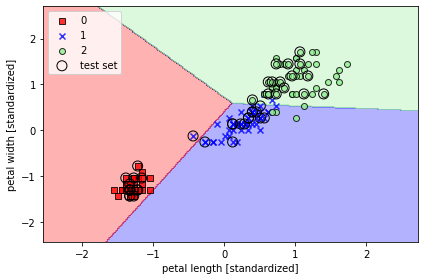

In [9]:
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

plot_decision_regions(X=X_combined_std, y=y_combined,
                      classifier=ppn, test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')

plt.tight_layout()
#plt.savefig('images/03_01.png', dpi=300)
plt.show()

# 3. Logistic regression
## 1. Logistic regression intuition and conditional probabilities
- Logistic sigmoid function allows us to transform values from the entire real-number range to the "probabilistic range", that is 0 to 1 range with an intercept at 0.5

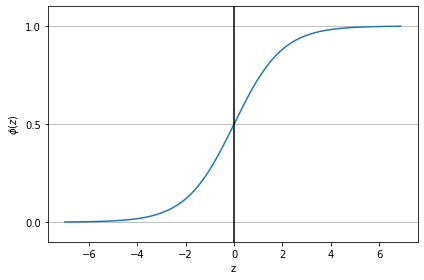

In [10]:
import matplotlib.pyplot as plt
import numpy as np


def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

z = np.arange(-7, 7, 0.1)
phi_z = sigmoid(z)

plt.plot(z, phi_z)
plt.axvline(0.0, color='k')
plt.ylim(-0.1, 1.1)
plt.xlabel('z')
plt.ylabel('$\phi (z)$')

# y axis ticks and gridline
plt.yticks([0.0, 0.5, 1.0])
ax = plt.gca()
ax.yaxis.grid(True)

plt.tight_layout()
#plt.savefig('images/03_02.png', dpi=300)
plt.show()

## 2. Learning the weights of the logistic cost function
- This is a visualisation of the meaning behind the "log-likelihood" cost function
- Essentially, the function consists of 2 logical parts, one of which becomes 0 depending on the true label of the sample, while the remaining one gives the "cost value", which goes up or down depending on the accuracy of the prediction (it grows exponentially with error) and which we want to minimize 

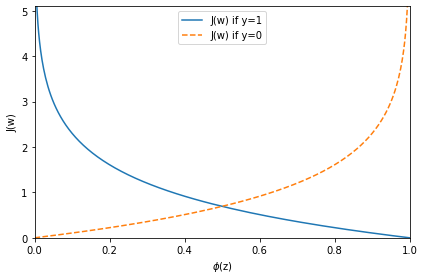

In [11]:
def cost_1(z):
    return - np.log(sigmoid(z))

def cost_0(z):
    return - np.log(1 - sigmoid(z))

z = np.arange(-10, 10, 0.1)
phi_z = sigmoid(z)

c1 = [cost_1(x) for x in z]
plt.plot(phi_z, c1, label='J(w) if y=1')

c0 = [cost_0(x) for x in z]
plt.plot(phi_z, c0, linestyle='--', label='J(w) if y=0')

plt.ylim(0.0, 5.1)
plt.xlim([0, 1])
plt.xlabel('$\phi$(z)')
plt.ylabel('J(w)')
plt.legend(loc='best')
plt.tight_layout()
#plt.savefig('images/03_04.png', dpi=300)
plt.show()

## 3. Implementing Logistic regression classifier on the base of Adaline classifier
- We only change 2 things: instead of using  identity function as the activation function we use logistic sigmoid function, and instead of returning labels -1 and 1 we return 0 and 1 (to correspond to the outputs from the sigmoid function)
- What is more important is that the weight update in logistic regression is equal to the equation that we used in Adaline with least-squares (the same partial derivatives!)

In [12]:
class LogisticRegressionGD(object):
    """Logistic Regression Classifier using gradient descent.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight
      initialization.


    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    cost_ : list
      Logistic cost function value in each epoch.

    """
    def __init__(self, eta=0.05, n_iter=100, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        Returns
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            
            # note that we compute the logistic `cost` now
            # instead of the sum of squared errors cost
            cost = -y.dot(np.log(output)) - ((1 - y).dot(np.log(1 - output)))
            self.cost_.append(cost)
        return self
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, z):
        """Compute logistic sigmoid activation"""
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, 0)
        # equivalent to:
        # return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)

## 4. Testing the Logistic regression classifier using the Iris dataset

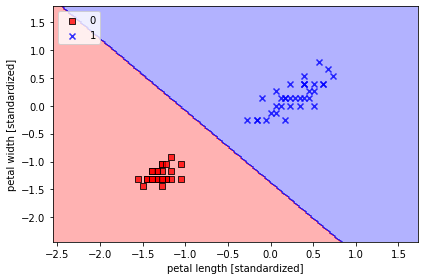

In [13]:
X_train_01_subset = X_train_std[(y_train == 0) | (y_train == 1)]
y_train_01_subset = y_train[(y_train == 0) | (y_train == 1)]

lrgd = LogisticRegressionGD(eta=0.05, n_iter=1000, random_state=1)
lrgd.fit(X_train_01_subset,
         y_train_01_subset)

plot_decision_regions(X=X_train_01_subset, 
                      y=y_train_01_subset,
                      classifier=lrgd)

plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')

plt.tight_layout()
#plt.savefig('images/03_05.png', dpi=300)
plt.show()

# 4. Logistic regression classifier in Scikit-learn
## 1. Training the classifier
- 'lbfgs' is a better optimization algorithm option for logistic regression classifier (according to the book)
- I decided to take a look at the difference betwee two techniques for multi-class classification, namely 'OvR' and 'multinomial'

In [14]:
from sklearn.linear_model import LogisticRegression

lr_ovr = LogisticRegression(C=100.0, random_state=1, solver='lbfgs', multi_class='ovr')
lr_ovr.fit(X_train_std, y_train)

lr_mult = LogisticRegression(C=100.0, random_state=1, solver='lbfgs', multi_class='multinomial')
lr_mult.fit(X_train_std, y_train)

LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

## 2. Predicting for the Iris dataset
- Despite achieving the same classification results for the given data, the "areas" of each class are very different, which will make quite a difference if we would introduce more testing samples

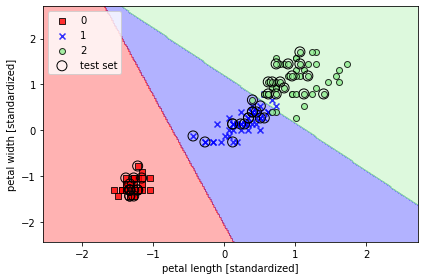

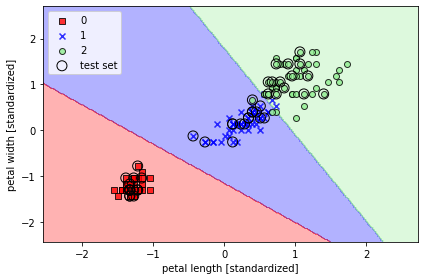

In [15]:
plot_decision_regions(X_combined_std, y_combined,
                      classifier=lr_ovr, test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
# plt.savefig('images/03_06.png', dpi=300)
plt.show()

plot_decision_regions(X_combined_std, y_combined,
                      classifier=lr_mult, test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
# plt.savefig('images/03_06.png', dpi=300)
plt.show()

## 3. Predicting probabilities and classes
### 1. predict_proba() - Predict class probabilities for all classes 

In [16]:
lr_ovr.predict_proba(X_test_std[:3, :])

array([[3.81527885e-09, 1.44792866e-01, 8.55207131e-01],
       [8.34020679e-01, 1.65979321e-01, 3.25737138e-13],
       [8.48831425e-01, 1.51168575e-01, 2.62277619e-14]])

### The sum of class probabilities for each sample is 1

In [17]:
lr_ovr.predict_proba(X_test_std[:3, :]).sum(axis=1)

array([1., 1., 1.])

### We can find the most probable class by finding the index of the highest probability

In [18]:
lr_ovr.predict_proba(X_test_std[:3, :]).argmax(axis=1)

array([2, 0, 0], dtype=int64)

### 2. predict() - Predict the most probable class label (combination of the 2 actions above)

In [19]:
lr_ovr.predict(X_test_std[:3, :])

array([2, 0, 0])

### To predict for 1 sample we need to convert it into a 2-dimensional array (the expected input is 2-dimensional)

In [20]:
lr_ovr.predict(X_test_std[0, :].reshape(1, -1))

array([2])

# 5. Tackling overfitting via regularization
- This graph illustrates that by decreasing the inverse-regularization parameter C the regularization strength increases and the weight consequently shrink towards 0

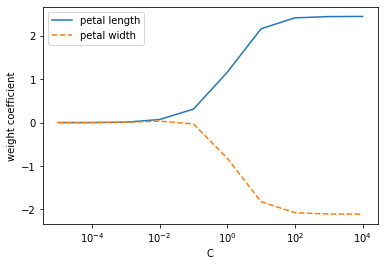

In [21]:
weights, params = [], []
for c in np.arange(-5, 5):
    lr = LogisticRegression(C=10.**c, random_state=1,
                            solver='lbfgs',
                            multi_class='ovr')
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10.**c)

weights = np.array(weights)
plt.plot(params, weights[:, 0],
         label='petal length')
plt.plot(params, weights[:, 1], linestyle='--',
         label='petal width')
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.legend(loc='upper left')
plt.xscale('log')
#plt.savefig('images/03_08.png', dpi=300)
plt.show()